In [1]:
import dmipy
import numpy as np
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.distributions.distribute_models import SD1WatsonDistributed
from dmipy.core.modeling_framework import MultiCompartmentModel
from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

No protocol specified


### One criticism of the NODDI model is its fixed free diffusivity at 3e-9 and parallel diffusivity at 1.7e-9. Perhaps with the ML approach, we can include some variability in the fixed diffusion values which may make the fitting more accurate/robust

In [24]:
%%capture

class NODDI_watson: #Input to class NODDI is all parameters needed to build the NODDI model
    def __init__(self,mu,ODI,watson_stick_frac,ball_frac,watson_frac,ball_diff=3e-9,par_free_diff=1.7e-9):
        '''
        ball_diff: fixed ball diffusivity (default=3e-9 m^2/s)
        mu: Orientation of watson distribution
        ODI: orientation dispersion index (between 0 and 1)
        watson_stick_frac: normalized fraction of stick w/i Watson bundle
        ball_frac: ball signal fraction
        watson_frac: fraction of watson component (combined intra- extracellular)
        par_free_diff: fixed parallel free diffusivity (default=1.7e-9 m^2/s)
        '''
        self.ball_diff = ball_diff
        self.mu = mu
        self.ODI = ODI
        self.watson_stick_frac = watson_stick_frac
        self.ball_frac = ball_frac
        self.watson_frac = watson_frac
        self.par_free_diff = par_free_diff

    def make_model(self):
        
        ball = gaussian_models.G1Ball()
        stick = cylinder_models.C1Stick()
        zeppelin = gaussian_models.G2Zeppelin()
        watson_bundle = SD1WatsonDistributed(models=[stick, zeppelin])

        watson_bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp','C1Stick_1_lambda_par','partial_volume_0')
        watson_bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
        watson_bundle.set_fixed_parameter('G2Zeppelin_1_lambda_par', self.par_free_diff) 

        NODDI_watson_model = MultiCompartmentModel(models=[ball, watson_bundle])
        NODDI_watson_model.set_fixed_parameter('G1Ball_1_lambda_iso', self.ball_diff)

        model_vector = NODDI_watson_model.parameters_to_parameter_vector(SD1WatsonDistributed_1_SD1Watson_1_mu=self.mu,
            SD1WatsonDistributed_1_SD1Watson_1_odi=self.ODI,SD1WatsonDistributed_1_partial_volume_0=self.watson_stick_frac, 
            partial_volume_0=self.ball_frac,partial_volume_1=self.watson_frac)
        
        return NODDI_watson_model,model_vector


    #def simulate_signal(self,acq_scheme):
        
       # fullmodel,modelvector = self.make_model()
        #signal = fullmodel.simulate_signal(acq_scheme,modelvector)
        
        #return signal

In [79]:
class generate_model_parameter_array:
    def __init__(self,numofsim):
        self.numofsim = numofsim

    def NODDI_watson(self):
        theta = np.random.uniform(0,np.pi,size=[self.numofsim,1])
        phi = np.random.uniform(0,2*np.pi,size=[self.numofsim,1])
        mu = np.c_[theta,phi]
        ODI = np.random.uniform(0.001,1,size=[self.numofsim,1])
        ballfrac = np.random.uniform(0.001,1,size=[self.numofsim,1])
        watsonfrac = 1 - ballfrac
        watsonstickfrac = np.random.uniform(0.001,1,size=[self.numofsim,1])

        parameter_array = np.c_[mu,ODI,watsonstickfrac,ballfrac,watsonfrac]

        return parameter_array

    #def DTI(self):


    #def SANDI(self):

In [21]:
def get_acq_scheme(bval,bvec):
    
    if type(bval) == str:
        bval = np.loadtxt(f'{bval}')
        bvec = np.loadtxt(f'{bvec}')

    if max(bval) < 1e8:
        print('Converting bvalues to s/m^2')
        bval = bval * 1e6

    acq_scheme = acquisition_scheme_from_bvalues(bval, bvec.T)
    return(acq_scheme)


In [80]:
%%capture
class simulate_SNR_signal:
  def __init__(self,model,parametervector,S0,SNR,acq_scheme):
    self.model = model
    self.parametervector = parametervector
    self.S0 = S0
    self.SNR = SNR
    self.acq_scheme = acq_scheme
  def simulate_true_signal(self):
    self.numofdata = self.acq_scheme.number_of_measurements
    self.simulated_data = np.empty((self.numofdata))
    self.simulated_data = self.model.simulate_signal(self.acq_scheme,self.parametervector)
    return self.simulated_data
  def simulate_noisy_signal(self):
    self.numofdata = self.acq_scheme.number_of_measurements
    sigma = self.S0 / self.SNR #SNR = S0 / std(noise)
    noise1 = np.random.normal(0, sigma, size=self.numofdata)
    self.noisy_signal = self.simulate_true_signal() + noise1
    return self.noisy_signal

class simulate_noisemap_signal:
  def __init__(self,model,noisemap,acq_scheme):
    self.model = model
    self.SNR = SNR
    self.bvals = bvals
    self.bvecs = bvecs
  def simulate_true_signal(self):
    self.numofdata = self.bvals.shape[0]
    self.simulated_data = np.empty((self.numofdata))
    for i in range(self.numofdata):
      self.simulated_data[i] = self.model.signal_representation(self.S0,self.bvals[i],self.bvecs[i,:])
    return self.simulated_data
  def simulate_noisy_signal(self):
    self.numofdata = self.bvals.shape[0]
    sigma = self.S0 / self.SNR #SNR = S0 / std(noise)
    noise1 = np.random.normal(0, sigma, size=self.numofdata)
    self.noisy_signal = self.simulate_true_signal() + noise1
    return(self.noisy_signal)

In [70]:
%%capture
def generate_NODDI_watson_training_data(numofsim,acq_scheme,S0,SNRarr): #Generate random array of NODDI parameters to then get our simulated signals

  numofacq = acq_scheme.number_of_measurements
  simulated_data = np.empty((numofsim,numofacq))

  parameter_array = generate_model_parameter_array(numofsim).NODDI_watson() #numofsim x 6 array

  for ii in range(numofsim):
    mu = parameter_array[ii,0:2]
    ODI = parameter_array[ii,2]
    watsonstickfrac = parameter_array[ii,3]
    ballfrac = parameter_array[ii,4]
    watsonfrac = parameter_array[ii,5]

    model,param_vector = NODDI_watson(mu,ODI,watsonstickfrac,ballfrac,watsonfrac).make_model()
    simulated_data[ii,:] = simulate_SNR_signal(model,param_vector,S0,SNRarr[ii],acq_scheme).simulate_noisy_signal()

  return simulated_data,parameter_array


In [30]:
%%capture
def diffsimgen(model,numofsim,bval,bvec,S0,SNR): #returns signal and parameter array for training
  if type(SNR) == int or len(SNR) == 1:
    SNRarr = np.tile(SNR,numofsim)
  elif len(SNR) == 2:
    SNRarr = np.random.uniform(SNR[0],SNR[1],size=[numofsim,1]) #if len(SNR) == 2 then assume that someone wants to randomly sample SNR between low and high
  else:
    SNRarr = np.tile(SNR,int(np.ceil(2030/len(SNR)))) #if len(SNR) > 2 then assume that someone wants to generate signal using all provided SNR values

  acq_scheme = get_acq_scheme(bval,bvec)
  function_name = f'generate_{model}_training_data'
  function = globals()[function_name]
    

  signal,parameters = function(numofsim,acq_scheme,S0,SNRarr)

  return signal,parameters

In [ ]:
function

In [109]:
%%capture

in_dir = '/scratch/bkarat/SANDI_fit_test/input/sub-01/dwi'

bvalues = np.loadtxt(f'{in_dir}/sub-01_CHARMED_dwi.bval')
bvecs = np.loadtxt(f'{in_dir}/sub-01_CHARMED_dwi.bvec')

signal,parameters = diffsimgen('NODDI_watson',10000,bvalues,bvecs,160,50)

## SNR for each shell

In [37]:
in_dir = '/home/ROBARTS/bkarat/graham/scratch/SANDI_fit_test/input/sub-01/dwi'
signalmask = nib.load(f'{in_dir}/signal_mask.nii.gz').get_fdata().flatten()
noisemask = nib.load(f'{in_dir}/noise_mask.nii.gz').get_fdata().flatten()

dwi = nib.load(f'{in_dir}/sub-01_CHARMED_dwi.nii.gz')
dwidata = dwi.get_fdata()
dwidata = np.reshape(dwidata,[-1,266])

bvalues = np.loadtxt(f'{in_dir}/sub-01_CHARMED_dwi.bval')
bvecs = np.loadtxt(f'{in_dir}/sub-01_CHARMED_dwi.bvec')


In [49]:
b0ind = bvalues==0
b200ind = bvalues==200
b500ind = bvalues==500
b1200ind = bvalues==1200
b2400ind = bvalues==2400

bind = np.c_[b0ind, b200ind,b500ind,b1200ind,b2400ind]
bunique = np.unique(bvalues)

for ii in range(5):
    signalhold = dwidata[signalmask==1,:]
    signal = np.mean(signalhold[:,bind[:,ii]])
    print(signal)
    noisehold = dwidata[noisemask==1,:]
    noise = np.std(noisehold[:,bind[:,ii]])
    SNR = signal/noise
    print(f'SNR={SNR} for b={bunique[ii]}')


198.3046897462104
SNR=36.14278501930628 for b=0.0
166.84126218577018
SNR=42.43274978804616 for b=200.0
132.6470095431072
SNR=37.79485554125643 for b=500.0
86.8906546403026
SNR=28.027385548769203 for b=1200.0
54.88615405975001
SNR=18.0922624362641 for b=2400.0


## Simulating from final toolbox

In [50]:
import sys
sys.path.append('/home/ROBARTS/bkarat/graham/DiffSimGen')
from diffsimgen import diffsimrun

in_dir = '/home/ROBARTS/bkarat/graham/scratch/SANDI_fit_test/input/sub-01/dwi'

bvalues = np.loadtxt(f'{in_dir}/sub-01_CHARMED_dwi.bval')
bvecs = np.loadtxt(f'{in_dir}/sub-01_CHARMED_dwi.bvec')

signal,parameters,parameter_names = diffsimrun(model='NODDI_watson',bval=bvalues,bvec=bvecs,S0=[50,200],SNR=[15,50],numofsim=100000)

Converting bvalues to s/m^2


In [52]:
Mdl = []
MLprediction = np.zeros((parameters.shape))
training_performances = []

    #Mdl[i] = sk.ensemble.BaggingRegressor(estimator=sklearn.tree.DecisionTreeRegressor(),n_estimators=n_trees,bootstrap=True,oob_score=True).fit(database_train,params_train[:,i])
RFregress = BaggingRegressor(n_estimators=300,bootstrap=True,oob_score=True)
Mdl.append(RFregress.fit(signal,parameters[:,2]))
#MLprediction[:,0] = Mdl[0].predict(signal)
    
#training_performances.append(Mdl[0].oob_score_)

In [54]:
import nibabel as nib

in_dir = '/home/ROBARTS/bkarat/graham/scratch/SANDI_fit_test/input/sub-01/dwi'
dwi = nib.load(f'{in_dir}/sub-01_CHARMED_dwi.nii.gz')
dwidata = dwi.get_fdata()
mask = nib.load(f'{in_dir}/sub-01_CHARMED_brain_mask.nii.gz').get_fdata().flatten()

In [55]:
#NORMALIZE DATA
dwidatatrain = np.reshape(dwidata,[-1,266])
indS0 = bvalues==0
dwidatatrainnorm = np.zeros((dwidatatrain.shape))
for ii in range(dwidatatrain.shape[0]):
    B0mean = np.mean(dwidatatrain[ii,indS0])
    dwidatatrainnorm[ii,:] = dwidatatrain[ii,:] / B0mean

In [63]:
ODImean = np.zeros((dwidatatrainnorm.shape[0],1))
maskind = mask==1
ODImean[maskind,0] = Mdl[0].predict(dwidatatrainnorm[maskind,:])

In [11]:
a,b,c,d = dwidata.shape
ODI = np.reshape(ODImean,[a,b,c])
img = nib.Nifti1Image(ODI,dwi.affine)
nib.save(img,f'{in_dir}/ODITEST.nii.gz')

### Now try building RF to go from noisy signal to parameters. Once built, try and run single subject image through (calculate SNR and S0 first) - perhaps try finding max and min SNR in the image and then just generate numofsim random integers between those numbers

In [348]:
Mdl = []
MLprediction = np.zeros((parameters.shape))
training_performances = []

for i in range(parameters.shape[1]):

    #Mdl[i] = sk.ensemble.BaggingRegressor(estimator=sklearn.tree.DecisionTreeRegressor(),n_estimators=n_trees,bootstrap=True,oob_score=True).fit(database_train,params_train[:,i])
    RFregress = BaggingRegressor(n_estimators=300,bootstrap=True,oob_score=True)
    Mdl.append(RFregress.fit(signal,parameters[:,i]))
    MLprediction[:,i] = Mdl[i].predict(signal)
    
    training_performances.append(Mdl[i].oob_score_)

In [83]:
Mdl = []
MLprediction = np.zeros((parameters.shape))
training_performances = []

    #Mdl[i] = sk.ensemble.BaggingRegressor(estimator=sklearn.tree.DecisionTreeRegressor(),n_estimators=n_trees,bootstrap=True,oob_score=True).fit(database_train,params_train[:,i])
RFregress = BaggingRegressor(n_estimators=300,bootstrap=True,oob_score=True)
Mdl.append(RFregress.fit(signal,parameters[:,2]))
MLprediction[:,0] = Mdl[0].predict(signal)
    
training_performances.append(Mdl[0].oob_score_)

In [85]:
import nibabel as nib

in_dir = '/home/ROBARTS/bkarat/graham/scratch/SANDI_fit_test/input/sub-01/dwi'
dwi = nib.load(f'{in_dir}/sub-01_CHARMED_dwi.nii.gz')
dwidata = dwi.get_fdata()
mask = nib.load(f'{in_dir}/sub-01_CHARMED_brain_mask.nii.gz').get_fdata().flatten()

In [108]:
#NORMALIZE DATA
dwidatatrain = np.reshape(dwidata,[-1,266])
indS0 = bvalues==0
dwidatatrainnorm = np.zeros((dwidatatrain.shape))
for ii in range(dwidatatrain.shape[0]):
    B0mean = np.mean(dwidatatrain[ii,indS0])
    dwidatatrainnorm[ii,:] = dwidatatrain[ii,:] / B0mean

In [366]:
mpgMean = np.zeros((dwidatatrain.shape[0],len(Mdl)))

for i in range(len(Mdl)):
    for jj in range(dwidatatrain.shape[0]):
        if mask[jj] == 1:
            mpgMean[:,i] = Mdl[i].predict(dwidatatrain[jj,:].reshape(1,-1))


KeyboardInterrupt: 

In [112]:
ODImean = np.zeros((dwidatatrainnorm.shape[0],1))
maskind = mask==1
ODImean[maskind,0] = Mdl[0].predict(dwidatatrainnorm[maskind,:])

In [113]:
a,b,c,d = dwidata.shape
ODI = np.reshape(ODImean,[a,b,c])

In [114]:
img = nib.Nifti1Image(ODI,dwi.affine)
nib.save(img,f'{in_dir}/ODITEST.nii.gz')

In [ ]:
    Mdl = []
    MLprediction = np.zeros((params_train.shape))
    Rsq = np.zeros((params_train.shape[1],1))
    Slope = np.zeros((params_train.shape[1],1))
    Intercept = np.zeros((params_train.shape[1],1))
    training_performances = []

    np.random.seed(1)

    for i in range(params_train.shape[1]):

        #Mdl[i] = sk.ensemble.BaggingRegressor(estimator=sklearn.tree.DecisionTreeRegressor(),n_estimators=n_trees,bootstrap=True,oob_score=True).fit(database_train,params_train[:,i])
        RFregress = BaggingRegressor(estimator=DecisionTreeRegressor(),n_estimators=n_trees,bootstrap=True,oob_score=True)
        Mdl.append(RFregress.fit(database_train,params_train[:,i]))
        MLprediction[:,i] = Mdl[i].predict(database_train)
        
        training_performances.append(Mdl[i].oob_score_)

        linmodel = LinearRegression()
        X = np.transpose(params_train[:,i]).reshape(-1,1)
        y = np.transpose(MLprediction[:,i]).reshape(-1,1)
        linmodel.fit(X,y)

        Slope[i] = linmodel.coef_
        Intercept[i] = linmodel.intercept_

In [107]:

mu = (np.pi / 2., np.pi / 2.)  # in radians
odi = 0.6
watsonstickfrac = 0.8
ballfrac = 0.6
watsonfrac = 0.4

nod = NODDI_watson(mu,odi,watsonstickfrac,ballfrac,watsonfrac)

nod.simulate_signal(acq_scheme).shape

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.


(266,)

In [ ]:
simsignal = diffsimgen(model,bval,bvec,numofsim,SNR,noisemap,)

In [ ]:
class single_tensor:
  def __init__(self,D):
    self.D = D
  def eigdecomp(self): #go from eigval and eigvec to tensor representation
    eig = np.linalg.eig(self.D)
    eigvals = eig[0]
    eigvecs = eig[1]
    return eigvals, eigvecs
  def signal_representation(self,S0,bval,bvecs):
    self.signal = S0 * np.exp((-np.transpose(bvecs) @ self.D @ bvecs)*bval)
    return self.signal
  def calculate_fractional_anisotropy(self):
    eigvals,eigvecs = self.eigdecomp()
    meaneigval = np.mean(eigvals)
    e1, e2, e3 = eigvals
    FA = np.sqrt(3/2) * ((np.sqrt((e1 - meaneigval)**2 +
                        (e2 - meaneigval)**2 + (e3 - meaneigval)**2)) /
                        np.sqrt(e1**2 + e2**2 + e3**2))
    return FA

### Consider just saving arrays for each model of parameter values to train across. This should not change based on acquisition, however maybe some would want to train on more or less parameters. Regardless, if we can fix this then can skip the step of randomly generating array of model parameters to train on

# Trying to build example simulation with NODDI

In [68]:
from dmipy.signal_models import cylinder_models, gaussian_models
ball = gaussian_models.G1Ball()
#ball.lambda_iso = 3e-9
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()

In [69]:
from dmipy.distributions.distribute_models import SD1WatsonDistributed
watson_dispersed_bundle = SD1WatsonDistributed(models=[stick, zeppelin])

In [70]:
watson_dispersed_bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp','C1Stick_1_lambda_par','partial_volume_0')
watson_dispersed_bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
watson_dispersed_bundle.set_fixed_parameter('G2Zeppelin_1_lambda_par', 1.7e-9)
#ball.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)

from dmipy.core.modeling_framework import MultiCompartmentModel
NODDI_mod = MultiCompartmentModel(models=[ball, watson_dispersed_bundle])
NODDI_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)

NODDI_mod.parameter_cardinality

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.


OrderedDict([('SD1WatsonDistributed_1_SD1Watson_1_mu', 2),
             ('SD1WatsonDistributed_1_SD1Watson_1_odi', 1),
             ('SD1WatsonDistributed_1_partial_volume_0', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

In [71]:
NODDI_mod.parameter_cardinality

OrderedDict([('SD1WatsonDistributed_1_SD1Watson_1_mu', 2),
             ('SD1WatsonDistributed_1_SD1Watson_1_odi', 1),
             ('SD1WatsonDistributed_1_partial_volume_0', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

In [88]:
import json
param_range = {}
param_range['theta'] = [0,np.pi]
param_range['phi'] = [-np.pi,np.pi]
param_range['odi'] = [0.02,0.99]
param_range['watsonstickfrac'] = [0.01,0.99]
param_range['ballfrac'] = [0.01,0.99]

with open('/home/ROBARTS/bkarat/graham/DiffSimGen/resources/NODDI_watson_parameter_range.json', 'w') as f: 
    json.dump(param_range, f)

In [89]:
with open('/home/ROBARTS/bkarat/graham/DiffSimGen/resources/NODDI_watson_parameter_range.json', 'r') as f:
    data = json.load(f)

In [80]:
NODDI_mod.parameter_ranges['partial_volume_0']

(0.01, 0.99)

### Set NODDI parameters for simulation

In [53]:
ball_lambda = 3e-9
mu = (np.pi / 2., np.pi / 2.)  # in radians
odi = 0.3
watsonstickfrac = 0.1
ballfrac = 0.9
watsonfrac = 0.1

parameter_vector = NODDI_mod.parameters_to_parameter_vector(
    SD1WatsonDistributed_1_SD1Watson_1_mu=mu,
    SD1WatsonDistributed_1_SD1Watson_1_odi=odi, SD1WatsonDistributed_1_partial_volume_0=watsonstickfrac, 
    partial_volume_0=ballfrac,partial_volume_1=watsonfrac)

parameter_vector

array([1.57079633, 1.57079633, 0.3       , 0.1       , 0.9       ,
       0.1       ])

### Load acq scheme

In [7]:
from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues

in_dir = '/home/ROBARTS/bkarat/graham/scratch/SANDI_fit_test/input/sub-01/dwi'

bvalues = np.loadtxt(f'{in_dir}/sub-01_CHARMED_dwi.bval')
bvals_SI = bvalues * 1e6
bvecs = np.loadtxt(f'{in_dir}/sub-01_CHARMED_dwi.bvec')

delta=None
Delta = None
TE = None
acq_scheme = acquisition_scheme_from_bvalues(bvals_SI, bvecs.T,delta,Delta)





# The delta and Delta times we know from the HCP documentation in seconds
#delta = 0.0106  
#Delta = 0.0431 

# The acquisition scheme we use in the toolbox is then created as follows:
#acq_scheme = acquisition_scheme_from_bvalues(bvalues_SI, gradient_directions, delta, Delta)


In [8]:
acq_scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 266
number of b0 measurements: 13
number of DWI shells: 6

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |13        |0               |N/A                      |N/A        |N/A       |N/A  
1           |20        |200             |N/A                      |N/A        |N/A       |N/A  
2           |20        |500             |N/A                      |N/A        |N/A       |N/A  
3           |30        |1200            |N/A                      |N/A        |N/A       |N/A  
4           |61        |2400            |N/A                      |N/A        |N/A       |N/A  
5           |61        |4000            |N/A                      |N/A        |N/A       |N/A  
6           |61        |6000            |N/A                      |N/A        |N/A       |N/A  


In [4]:
acq_scheme.summary()

AttributeError: 'DmipyAcquisitionScheme' object has no attribute 'summary'

In [55]:
bvecs.shape

(3, 266)

### Simulate signal

In [56]:
NODDI_simulate = NODDI_mod.simulate_signal(acq_scheme, parameter_vector)
len(NODDI_simulate)  # See that this produces the signal attenuation for the entire acquisition scheme

266

In [57]:
bunique = np.unique(bvalues)
s1 = np.zeros((len(bunique)))

for ii in range(len(bunique)):
    bind = bvalues == bunique[ii]
    s1[ii] = np.mean(NODDI_simulate[bind])

In [58]:
from scipy.fft import fft, fftfreq
import numpy as np

from scipy.optimize import curve_fit
# Function to calculate the exponential with constants a and b
def monoexp(x, m, t):
    return m * np.exp(-t * x)

barray = np.linspace(0,6000,100)

p0 = (1,0.0000003 ) # start with values near those we expect

params1,cv = curve_fit(monoexp,bunique,s1,p0)

s1fit = monoexp(barray,params1[0],params1[1])


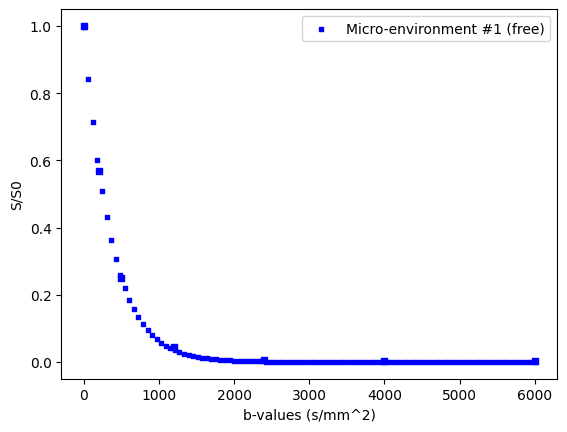

In [59]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(barray, s1fit, s=10, c='b', marker="s", label='Micro-environment #1 (free)')
ax1.scatter(bunique, s1, s=20, c='b', marker="s")
plt.legend(loc='upper right')
plt.xlabel("b-values (s/mm^2)")
plt.ylabel("S/S0")
plt.show()

In [60]:
#B0 AND B1000 ONLY FOR FT
bunique = np.unique(bvalues)[0:4]

sb1000 = np.zeros((4))

for ii in range(len(bunique)):
    bind = bvalues==bunique[ii]
    sb1000[ii] = np.mean(NODDI_simulate[bind])

In [61]:
barray = np.linspace(0,1200,100)

p0 = (1,0.0000003 ) # start with values near those we expect

params1,cv = curve_fit(monoexp,bunique,sb1000,p0)

s1fit = monoexp(barray,params1[0],params1[1])

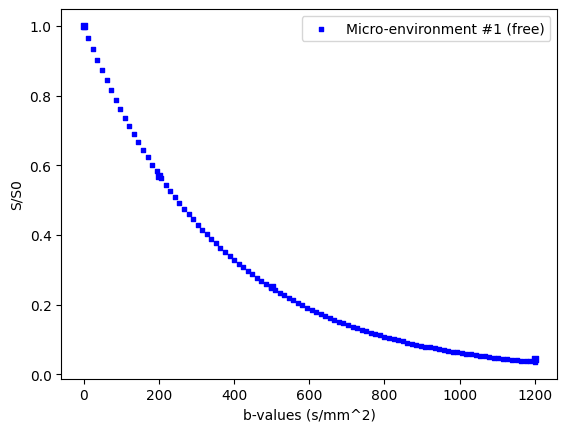

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(barray, s1fit, s=10, c='b', marker="s", label='Micro-environment #1 (free)')
ax1.scatter(bunique, sb1000, s=20, c='b', marker="s")
plt.legend(loc='upper right')
plt.xlabel("b-values (s/mm^2)")
plt.ylabel("S/S0")
plt.show()

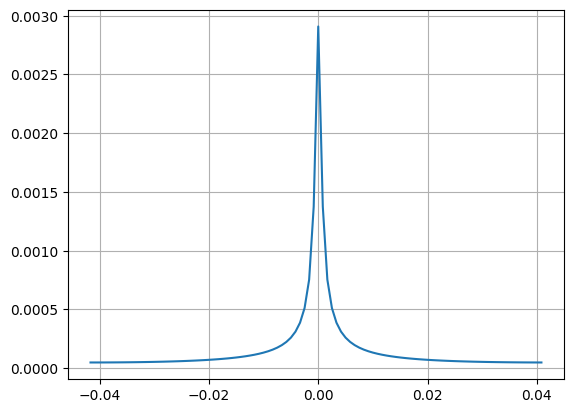

In [67]:
from scipy.fft import fft, fftfreq, fftshift, ifft

import numpy as np

# Number of sample points

N = 100
# sample spacing
T = 1200 / 100

yf = ifft(s1fit)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)

import matplotlib.pyplot as plt

plt.plot(xf, 1.0/N * np.abs(yplot))

plt.grid()

plt.show()

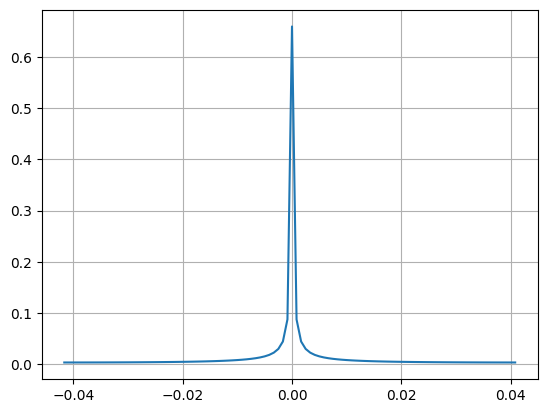

In [52]:
from scipy.fft import fft, fftfreq, fftshift

import numpy as np

# Number of sample points

N = 100
# sample spacing
T = 1200 / 100

yf = fft(s1fit)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)

import matplotlib.pyplot as plt

plt.plot(xf, 1.0/N * np.abs(yplot))

plt.grid()

plt.show()

In [117]:
res = NODDI_mod.fit(acq_scheme, NODDI_simulate)

Setup brute2fine optimizer in 1.7437341213226318 seconds
Fitting of 1 voxels complete in 0.06595540046691895 seconds.
Average of 0.06595540046691895 seconds per voxel.


In [118]:
(print ('Optimized result:', res.fitted_parameters_vector))
(print ('Ground truth:    ', parameter_vector))

Optimized result: [[ 1.56915801 -1.56780756  0.60140646  0.80016357  0.6000631   0.3999369 ]]
Ground truth:     [1.57079633 1.57079633 0.6        0.8        0.6        0.4       ]


In [123]:
ball.lambda_iso = 3e-9

In [ ]:
class single_tensor:
  def __init__(self,D):
    self.D = D
  def eigdecomp(self): #go from eigval and eigvec to tensor representation
    eig = np.linalg.eig(self.D)
    eigvals = eig[0]
    eigvecs = eig[1]
    return eigvals, eigvecs
  def signal_representation(self,S0,bval,bvecs):
    self.signal = S0 * np.exp((-np.transpose(bvecs) @ self.D @ bvecs)*bval)
    return self.signal
  def calculate_fractional_anisotropy(self):
    eigvals,eigvecs = self.eigdecomp()
    meaneigval = np.mean(eigvals)
    e1, e2, e3 = eigvals
    FA = np.sqrt(3/2) * ((np.sqrt((e1 - meaneigval)**2 +
                        (e2 - meaneigval)**2 + (e3 - meaneigval)**2)) /
                        np.sqrt(e1**2 + e2**2 + e3**2))
    return FA